## Project Description

To build an algorithm to detect a visual signal for pneumonia in medical images. Specifically, the algorithm needs to automatically locate lung opacities on chest radiographs.

## Dataset

The dataset contains the following files and folders:
-	stage_2_train_labels.csv - The training set. It contains patientIds and bounding box / target information.
-	stage_2_detailed_class_info.csv – It provides detailed information about the type of positive or negative class for each image.

Apart from the above-mentioned data files (in csv format), the dataset also contains the images folders 
-	stage_2_train_images
-	stage_2_test_images
 
The images in the above-mentioned folders are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

## Objective

The objective of this task is to do Pre-Processing, Data Visualization, EDA which will involve the following tasks to be done:
-	Exploring the given Data files, classes and images of different classes
-	Dealing with missing values
-	Visualization of different classes
-	Analysis from the visualization of different classes.


In [1]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.4.1'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import os

cwd_old = os.getcwd()
print('\nWorking Directory: ', cwd_old)

os.chdir('/content/gdrive/MyDrive/AIML/Projects/CV - Pneumonia Detection')
print('Working directory has been changed')

cwd_new = os.getcwd()
print('\nCurrent Working Directory: ', cwd_new)


Working Directory:  /content
Working directory has been changed

Current Working Directory:  /content/gdrive/MyDrive/AIML/Projects/CV - Pneumonia Detection


In [4]:
#data_dir = os.path.join(cwd_new + 'data/')
#train_images = os.path.join(data_dir + 'stage_2_train_images/')
#test_images = os.path.join(data_dir + 'stage_2_test_images/')
#output_dir = os.path.join(cwd_new + 'output/')

# No need to run these commands from now on as the directory has been created:
#if not os.path.exists(data_dir):
#  os.makedirs(data_dir)

#if not os.path.exists(train_images):
#  os.makedirs(train_images)

#if not os.path.exists(test_images):
#  os.makedirs(test_images)

#if not os.path.exists(output_dir):
#  os.makedirs(output_dir)

In [5]:
#Follwing series of commands related to kaggle need not to be executed as the dataset has been downloaded:
#!pip install -q kaggle

In [6]:
#Upgrading the kaggle installation
#!pip install --upgrade --force-reinstall --no-deps kaggle

In [7]:
#Choose the kaggle.json file that you downloaded
#from google.colab import files
#files.upload()

In [8]:
#Make directory named kaggle and copy kaggle.json file there.
#!mkdir ~/.kaggle

In [9]:
#! cp kaggle.json ~/.kaggle/

In [10]:
#Change the permissions of the file.
#! chmod 600 ~/.kaggle/kaggle.json

In [11]:
#To check if everything's okay or not
#!kaggle datasets list

In [12]:
#Download the Pneumonia Detection Dataset
#!kaggle competitions download -c rsna-pneumonia-detection-challenge

In [13]:
# Unzipping the dowloaded dataset

#import zipfile

#file_name = 'rsna-pneumonia-detection-challenge.zip'

#extract_file = zipfile.ZipFile(file_name, 'r')
#extract_file.extractall()

#### Import Packages

In [14]:
## ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [15]:
!pip install pydicom

     |████████████████████████████████| 1.9MB 7.3MB/s 


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
import pydicom as dcm
from glob import glob
from skimage.transform import resize
from skimage import io, measure
import cv2, random

import tensorflow as tf
from tensorflow import keras

In [17]:
#print('Current Working Directory: {}'.format(os.getcwd()))
#print('Folders and Files present in the current directory: {}'.format(os.listdir()))

#### Preparation of Train Dataset

#### Reading CSV files

Out of the all the files and folders listed above we will start working with two csv files: **stage_2_train_labels.csv** and **stage_2_detailed_class_info.csv**.

- **stage_2_train_labels.csv**

It is the training set. It contains the patientId s and bounding box/target information

In [18]:
train_labels = pd.read_csv('stage_2_train_labels.csv')
print('First five rows of Training set:\n', train_labels.head())

First five rows of Training set:
                               patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


Some information about the data field present in the 'stage_2_train_labels.csv' are:
*   **patientId** - A patientId. Each patientId corresponds to a unique image (which we will see a little bit later) 
*   **x** - The upper-left x coordinate of the bounding box
*   **y** - The upper-left y coordinate of the bounding box
*   **width** - The width of the bounding box
*   **height** - The height of the bounding box
*   **Target** - The binary Target indicating whether this sample has evidence of pneumonia or not.




In [19]:
# Number of entries in Train label dataframe:
print('The train_label dataframe has {} rows and {} columns.'.format(train_labels.shape[0], train_labels.shape[1]))

The train_label dataframe has 30227 rows and 6 columns.


In [20]:
# Number of duplicates in patientId:
print('Number of unique patientId are: {}'.format(train_labels['patientId'].nunique()))

Number of unique patientId are: 26684


Thus, the dataset contains information about 26684 patients. Out of these 26684 patients, some of them have multiple entries in the dataset.

No of entries which has Pneumonia: 9555 i.e., 32.0%
No of entries which don't have Pneumonia: 20672 i.e., 68.0%


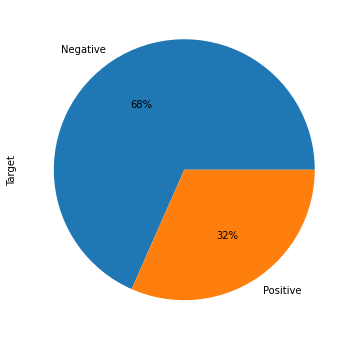

In [21]:
print(f'No of entries which has Pneumonia: {train_labels[train_labels.Target == 1].shape[0]} i.e., {round(train_labels[train_labels.Target == 1].shape[0]/train_labels.shape[0]*100, 0)}%')
print(f'No of entries which don\'t have Pneumonia: {train_labels[train_labels.Target == 0].shape[0]} i.e., {round(train_labels[train_labels.Target == 0].shape[0]/train_labels.shape[0]*100, 0)}%')
_ = train_labels['Target'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Negative', 'Positive'], figsize = (10, 6))

Thus, from the above pie chart it is clear that out of 30227 entries in the dataset, there are 20672 (i.e., 68%) entries in the dataset which corresponds to the entries of the patient Not having Pnuemonia whereas 9555 (i.e., 32%) entries corresponds to Positive case of Pneumonia.

In [22]:
# Checking nulls in bounding box columns:
print('Number of nulls in bounding box columns: {}'.format(train_labels[['x', 'y', 'width', 'height']].isnull().sum().to_dict()))

Number of nulls in bounding box columns: {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}


Thus, we can see that number of nulls in bounding box columns are equal to the number of 0's we have in the Target column.

In [23]:
bounding_box = train_labels.groupby('patientId').size().to_frame('number_of_boxes').reset_index()
train_labels = train_labels.merge(bounding_box, on = 'patientId', how = 'left')
print('Number of patientIds per bounding box in the dataset: ')
(bounding_box.groupby('number_of_boxes').size().to_frame('number_of_patientId').reset_index().set_index('number_of_boxes').sort_values(by = 'number_of_boxes'))

Number of patientIds per bounding box in the dataset: 


,number_of_patientId
number_of_boxes,
1,23286
2,3266
3,119
4,13


Thus, there are 23286 unique patients which have only one entry in the dataset. It also has the patientsbounding box, 3266 with 2 bounding box, 119 with 3 bounding box and 13 with 4 bounding box coordinates.

- **stage_2_detailed_class_info.csv**

It provides detailed information about the type of positive or negative class for each image.


In [24]:
class_labels = pd.read_csv('stage_2_detailed_class_info.csv')
print('First five rows of Class label dataset are:\n', class_labels.head())

First five rows of Class label dataset are:
                               patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity


Some information about the data field present in the 'stage_2_detailed_class_info.csv' are:
*   **patientId** - A patientId. Each patientId corresponds to a unique image
*   **class** - Have three values depending what is the current state of the patient's lung: 'No Lung Opacity / Not Normal', 'Normal' and 'Lung Opacity'.



In [25]:
# Number of entries in class_label dataframe:
print('The class_label dataframe has {} rows and {} columns.'.format(class_labels.shape[0], class_labels.shape[1]))

The class_label dataframe has 30227 rows and 2 columns.


In [26]:
# Number of duplicates in patients:
print('Number of unique patientId are: {}'.format(class_labels['patientId'].nunique()))

Number of unique patientId are: 26684


Thus, the dataset contains information about 26684 patients (which is same as that of the train_labels dataframe).



In [27]:
def get_feature_distribution(data, feature):
  # Count for each label
  label_counts = data[feature].value_counts()
  # Count the number of items in each class
  total_samples = len(data)
  print("Feature: {}".format(feature))
  for i in range(len(label_counts)):
    label = label_counts.index[i]
    count = label_counts.values[i]
    percent = int((count / total_samples) * 10000) / 100
    print("{:<30s}: {} which is {}% of the total data in the dataset".format(label, count, percent))

In [28]:
get_feature_distribution(class_labels, 'class')

Feature: class
No Lung Opacity / Not Normal  : 11821 which is 39.1% of the total data in the dataset
Lung Opacity                  : 9555 which is 31.61% of the total data in the dataset
Normal                        : 8851 which is 29.28% of the total data in the dataset


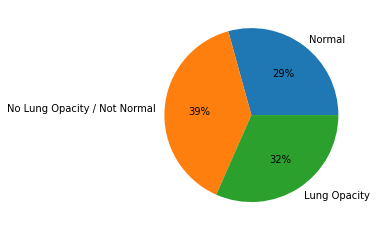

In [29]:
figsize = (10, 6)
_ = class_labels['class'].value_counts().sort_index(ascending = False).plot(kind = 'pie', autopct = '%.0f%%').set_ylabel('')

In [30]:
# Checking nulls in class_labels:
print('Number of nulls in class columns: {}'.format(class_labels['class'].isnull().sum()))

Number of nulls in class columns: 0


Thus, none of the columns in class_labels has an empty row. 

In [31]:
# Checking whether each patientId has only one type of class or not
class_labels.groupby(['patientId'])['class'].nunique().max()

1

Thus, we can say that each patientId is associated with only 1 class.

In [32]:
# Merging the two dataset - 'train_labels' and 'class_labels':
training_data = pd.concat([train_labels, class_labels['class']], axis = 1)
print('After merging, the dataset looks like: \n')
training_data.head()

After merging, the dataset looks like: 



,patientId,x,y,width,height,Target,number_of_boxes,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity


In [33]:
print('After merge, the dataset has {} rows and {} columns.'.format(training_data.shape[0], training_data.shape[1]))

After merge, the dataset has 30227 rows and 8 columns.


#### Target and Class

Text(0.5, 1.0, 'Class and Target for Chest Exams')

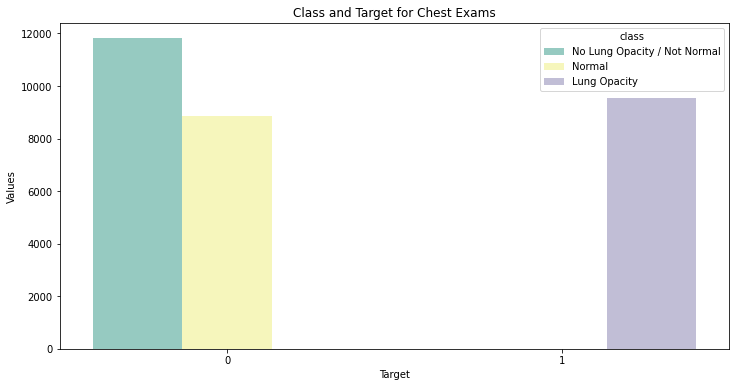

In [34]:
fig, ax = plt.subplots(nrows = 1, figsize = (12, 6))
temp = training_data.groupby('Target')['class'].value_counts()
data_target_class = pd.DataFrame(data = {'Values': temp.values}, index = temp.index).reset_index()
sns.barplot(ax = ax, x = 'Target', y = 'Values', hue = 'class', data = data_target_class, palette = 'Set3')
plt.title('Class and Target for Chest Exams')

Thus, **Target = 1** is associated with only **class = Lung Opacity** whereas **Target = 0** is associated with only **class = No Lung Opacity / Not Normal** as well as **Normal**.

#### Bounding Box Distribution

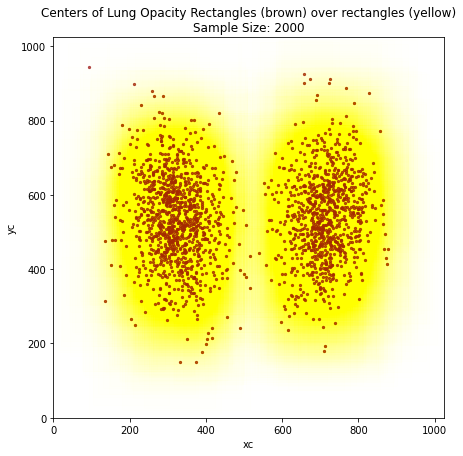

In [35]:
fig, ax = plt.subplots(1, 1, figsize = (7, 7))
target_1 = training_data[training_data['Target'] == 1]
target_sample = target_1.sample(2000)
target_sample['xc'] = target_sample['x'] + target_sample['width'] / 2
target_sample['yc'] = target_sample['y'] + target_sample['height'] / 2
plt.title('Centers of Lung Opacity Rectangles (brown) over rectangles (yellow)\nSample Size: 2000')
target_sample.plot.scatter(x = 'xc', y = 'yc', xlim = (0, 1024), ylim = (0, 1024), ax = ax, alpha = 0.8, marker = '.', color = 'brown')

for i, crt_sample in target_sample.iterrows():
    ax.add_patch(Rectangle(xy=(crt_sample['x'], crt_sample['y']),
                width=crt_sample['width'],height=crt_sample['height'],alpha=3.5e-3, color="yellow"))

Thus, we can see that the centers for the bounding box are spread out evenly across the Lungs. Though a large portion of the bounding box have their centers at the centers of the Lung, but some centers of the box are also located at the edges of lung. 

#### Reading Images

Images provided are stored in DICOM (.dcm) format which is an international standard to transmit, store, retrieve, print, process, and display medical imaging information. Digital Imaging and Communications in Medicine (DICOM) makes medical imaging information interoperable. We will make use of pydicom package here to read the images.

In [36]:
sample_patientId = train_labels['patientId'][0]
dcm_file = '/content/gdrive/MyDrive/AIML/Projects/CV - Pneumonia Detection/stage_2_train_images/'+'{}.dcm'.format(sample_patientId)
dcm_data = dcm.read_file(dcm_file)

print('Metadata of the image consists of \n', dcm_data)

Metadata of the image consists of 
 Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008, 0020) Study Date                          DA: '190

From the above sample we can see that dicom file contains some of the information that can be used for further analysis such as sex, age, body part examined (which should be mostly chest), view position and modality. Size of this image is 1024 x 1024 (rows x columns).

In [37]:
print('Number of images in training images folders are: {}.'.format(len(os.listdir('/content/gdrive/MyDrive/AIML/Projects/CV - Pneumonia Detection/stage_2_train_images'))))

Number of images in training images folders are: 26684.


Thus, we can see that in the training images folder we have just 26684 images which is same as that of unique patientId's present in either of the csv files. Thus, we can say that **each of the unique patientId's present in either of the csv files corresponds to an image present in the folder**.

In [38]:
training_image_path = '/content/gdrive/MyDrive/AIML/Projects/CV - Pneumonia Detection/stage_2_train_images/'

images = pd.DataFrame({'path': glob(os.path.join(training_image_path, '*.dcm'))})
images['patientId'] = images['path'].map(lambda x:os.path.splitext(os.path.basename(x))[0])
print('Columns in the training images dataframe: {}'.format(list(images.columns)))

Columns in the training images dataframe: ['path', 'patientId']


In [39]:
# Merging the images dataframe with training_data dataframe
training_data = training_data.merge(images, on = 'patientId', how = 'left')
print('After merging the two dataframe, the training_data has {} rows and {} columns.'.format(training_data.shape[0], training_data.shape[1]))

After merging the two dataframe, the training_data has 30227 rows and 9 columns.


In [40]:
print('The training_data dataframe as of now stands like\n')
training_data.head()

The training_data dataframe as of now stands like



,patientId,x,y,width,height,Target,number_of_boxes,class,path
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/gdrive/MyDrive/AIML/Projects/CV - Pne...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/gdrive/MyDrive/AIML/Projects/CV - Pne...
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/gdrive/MyDrive/AIML/Projects/CV - Pne...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,/content/gdrive/MyDrive/AIML/Projects/CV - Pne...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,/content/gdrive/MyDrive/AIML/Projects/CV - Pne...


In [41]:
columns_to_add = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined', 'ViewPosition', 'ConversionType', 'Rows', 'Columns', 'PixelSpacing']

def parse_dicom_data(data_df, data_path):
  for col in columns_to_add:
    data_df[col] = None
  image_names = os.listdir('/content/gdrive/MyDrive/AIML/Projects/CV - Pneumonia Detection/stage_2_train_images/')
  
  for i, img_name in tqdm_notebook(enumerate(image_names)):
    imagepath = os.path.join('/content/gdrive/MyDrive/AIML/Projects/CV - Pneumonia Detection/stage_2_train_images/', img_name)
    data_img = dcm.read_file(imagepath)
    idx = (data_df['patientId'] == data_img.PatientID)
    data_df.loc[idx, 'Modality'] = data_img.Modality
    data_df.loc[idx, 'PatientAge'] = pd.to_numeric(data_img.PatientAge)
    data_df.loc[idx, 'PatientSex'] = data_img.PatientSex
    data_df.loc[idx, 'BodyPartExamined'] = data_img.BodyPartExamined
    data_df.loc[idx, 'ViewPosition'] = data_img.ViewPosition
    data_df.loc[idx, 'ConversionType'] = data_img.ConversionType
    data_df.loc[idx, 'Rows'] = data_img.Rows
    data_df.loc[idx, 'Columns'] = data_img.Columns
    data_df.loc[idx, 'PixelSpacing'] = str.format("{:4.3f}", data_img.PixelSpacing[0])

In [ ]:
parse_dicom_data(training_data, '/content/gdrive/MyDrive/AIML/Projects/CV - Pneumonia Detection/stage_2_train_images/')

In [ ]:
print('So after parsing the information from the dicom images, our training_data dataframe has {} rows and {} columns and it looks like:\n'.format(training_data.shape[0], training_data.shape[1]))
training_data.head()

So after parsing the information from the dicom images, our training_data dataframe has 30227 rows and 18 columns and it looks like:



,patientId,x,y,width,height,Target,number_of_boxes,class,path,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/gdrive/MyDrive/AIML/Projects/CV - Pne...,CR,51,F,CHEST,PA,WSD,1024,1024,0.143
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/gdrive/MyDrive/AIML/Projects/CV - Pne...,CR,48,F,CHEST,PA,WSD,1024,1024,0.194
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/gdrive/MyDrive/AIML/Projects/CV - Pne...,CR,19,M,CHEST,AP,WSD,1024,1024,0.168
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,/content/gdrive/MyDrive/AIML/Projects/CV - Pne...,CR,28,M,CHEST,PA,WSD,1024,1024,0.143
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,/content/gdrive/MyDrive/AIML/Projects/CV - Pne...,CR,32,F,CHEST,AP,WSD,1024,1024,0.139


In [ ]:
# Saving the training_data for further use:
training_data.to_pickle('training_data.pkl')

Going forward we will now use this pickle file as our training data.

EDA on this saved training data:

In [42]:
training_data = pd.read_pickle('training_data.pkl')
print(f'Our training data consists of {training_data.shape[0]} rows and {training_data.shape[1]} columns and looks like as: \n')
training_data.head()

Our training data consists of 30227 rows and 18 columns and looks like as: 



,patientId,x,y,width,height,Target,number_of_boxes,class,path,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/gdrive/MyDrive/AIML/Projects/CV - Pne...,CR,51,F,CHEST,PA,WSD,1024,1024,0.143
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/gdrive/MyDrive/AIML/Projects/CV - Pne...,CR,48,F,CHEST,PA,WSD,1024,1024,0.194
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/gdrive/MyDrive/AIML/Projects/CV - Pne...,CR,19,M,CHEST,AP,WSD,1024,1024,0.168
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,/content/gdrive/MyDrive/AIML/Projects/CV - Pne...,CR,28,M,CHEST,PA,WSD,1024,1024,0.143
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,/content/gdrive/MyDrive/AIML/Projects/CV - Pne...,CR,32,F,CHEST,AP,WSD,1024,1024,0.139


#### Modality

In [43]:
print('Modality for the images obtained is: {} \n'.format(training_data['Modality'].unique()[0]))

Modality for the images obtained is: CR 



#### Body Part Examined

In [44]:
print('The images obtained are of {} areas.'.format(training_data['BodyPartExamined'].unique()[0]))

The images obtained are of CHEST areas.


#### Understanding Different Positions

In [45]:
get_feature_distribution(training_data, 'ViewPosition')

Feature: ViewPosition
AP                            : 15297 which is 50.6% of the total data in the dataset
PA                            : 14930 which is 49.39% of the total data in the dataset


As seen above, two View Positions that are in the training dataset are AP (Anterior/Posterior) and PA (Posterior/Anterior). These type of X-rays are mostly used to obtain the front-view. Apart from front-view, a lateral image is usually taken to complement the front-view.
- **Posterior/Anterior (PA)**: Here the chest radiograph is acquired by passing the X-Ray beam from the patient's posterior (back) part of the chest  to the anterior (front) part. While obtaining the image patient is asked to stand with their chest against the film. In this image, the hear is on the right side of the image as one looks at it. These are of higher quality and assess the heart size more accurately
- **Anterior/Posterior (AP)**: At times it is not possible for radiographers to acquire a PA chest X-ray. This is usually because the patient is too unwell to stand. In these images the size of Heart is exaggerated.

The distribution of View Position when there is an evidence of Pneumonia:



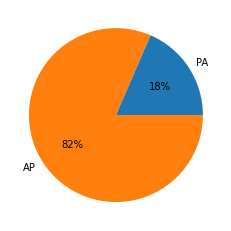

In [46]:
print('The distribution of View Position when there is an evidence of Pneumonia:\n')
_ = training_data.loc[training_data['Target'] == 1, 'ViewPosition'].value_counts().sort_index(ascending = False).plot(kind = 'pie', autopct = '%.0f%%').set_ylabel('')

Plot x and y centers of bounding box


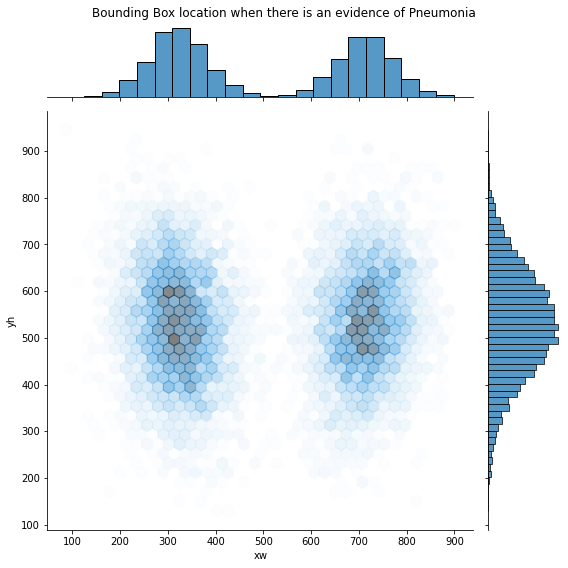

In [47]:
print('Plot x and y centers of bounding box')
bboxes = training_data[training_data['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width']/2
bboxes['yh'] = bboxes['y'] + bboxes['height']/2

g = sns.jointplot(x = bboxes['xw'], y = bboxes['yh'], data = bboxes,
                  kind = 'hex', alpha = 0.5, size = 8)
plt.suptitle('Bounding Box location when there is an evidence of Pneumonia')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)

In [48]:
def bboxes_scatter(data, color_point, color_window, text):
  fig, ax = plt.subplots(1, 1, figsize = (7, 7))
  plt.title('Plotting centers of Lung Opacity\n{}'.format(text))
  data.plot.scatter(x = 'xw', y = 'yh', xlim = (0, 1024), ylim = (0, 1024), ax = ax, alpha = 0.8, marker = ".", color = color_point)
  for i, crt_sample in data.iterrows():
    ax.add_patch(Rectangle(xy = (crt_sample['x'], crt_sample['y']), width = crt_sample['width'], height = crt_sample['height'], alpha = 3.5e-3, color = color_window))

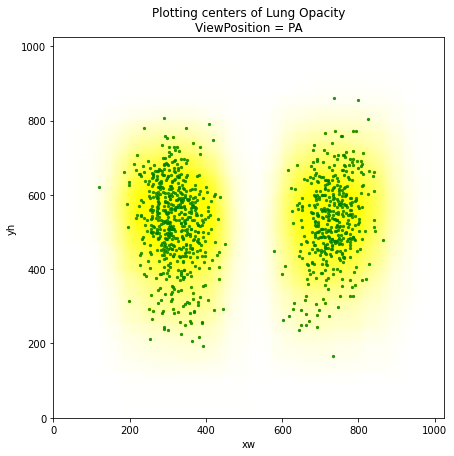

In [49]:
data_PA = bboxes[bboxes['ViewPosition'] == 'PA'].sample(1000)
data_AP = bboxes[bboxes['ViewPosition'] == 'AP'].sample(1000)

bboxes_scatter(data_PA, 'green', 'yellow', 'ViewPosition = PA')

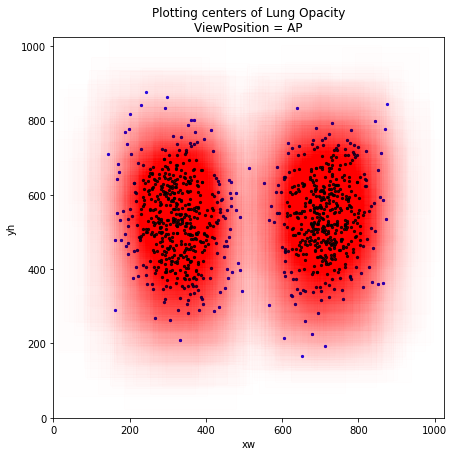

In [50]:
bboxes_scatter(data_AP, 'blue', 'red', 'ViewPosition = AP')

We can see that the centers of the box are spread across the entire region of the Lungs. Both of the cases (PA and AP) seem to have outliers in them.  

#### Conversion Type

In [51]:
print('Conversion Type for the data in Training Data: ', training_data['ConversionType'].unique()[0])

Conversion Type for the data in Training Data:  WSD


#### Rows and Columns

In [52]:
print(f'The training images has {training_data.Rows.unique()[0]} rows and {training_data.Columns.unique()[0]} columns.')

The training images has 1024 rows and 1024 columns.


#### Patient Sex

In [53]:
def drawgraphs(data_file, columns, hue = False, width = 15, showdistribution = True):
  if (hue):
    print('Creating graph for: {} and {}'.format(columns, hue))
  else:  
    print('Creating graph for : {}'.format(columns))
  length = len(columns) * 6
  total = float(len(data_file))

  fig, axes = plt.subplots(nrows = len(columns) if len(columns) > 1 else 1, ncols = 1, figsize = (width, length))
  for index, content in enumerate(columns):
    plt.title(content)

    currentaxes = 0
    if (len(columns) > 1):
      currentaxes = axes[index]
    else:
      currentaxes = axes

    if (hue):
      sns.countplot(x = columns[index], data = data_file, ax = currentaxes, hue = hue)
    else:
      sns.countplot(x = columns[index], data = data_file, ax = currentaxes)

    if(showdistribution):
      for p in (currentaxes.patches):
        height = p.get_height()
        if (height > 0 and total > 0):
          currentaxes.text(p.get_x() + p.get_width()/2., height + 3, '{:1.2f}%'.format(100*height/total), ha = "center")

Creating graph for : ['PatientSex']


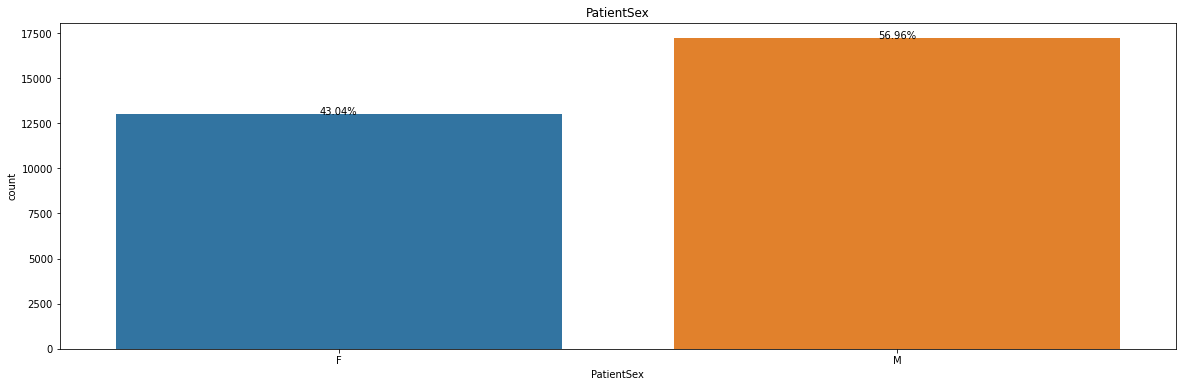

In [54]:
drawgraphs(data_file = training_data, columns = ['PatientSex'], hue = False, width = 20, showdistribution = True)

In [55]:
get_feature_distribution(training_data, 'PatientSex')

Feature: PatientSex
M                             : 17216 which is 56.95% of the total data in the dataset
F                             : 13011 which is 43.04% of the total data in the dataset


Thus, out of 30227 records, there are 17216 records of M (Male) and 13011 records of F (Female).

Creating graph for: ['PatientSex'] and class


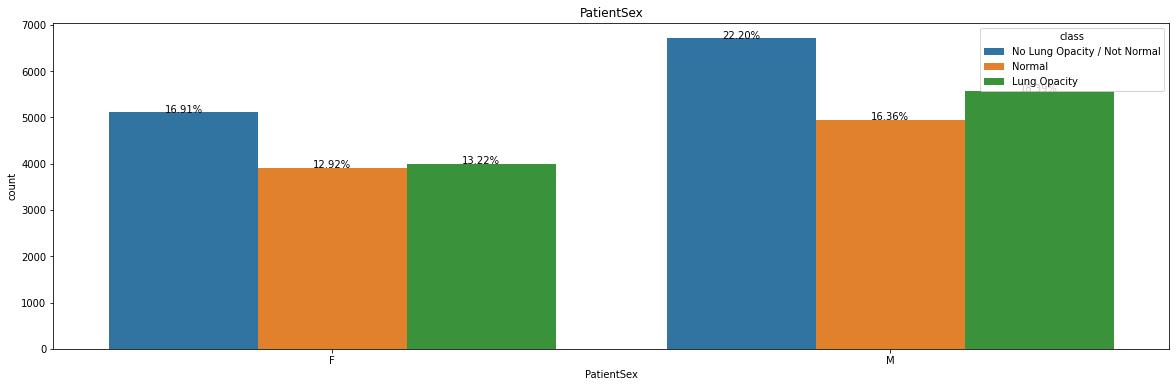

In [56]:
drawgraphs(data_file = training_data, columns = ['PatientSex'], hue = 'class', width = 20, showdistribution = True)

Creating graph for: ['PatientSex'] and Target


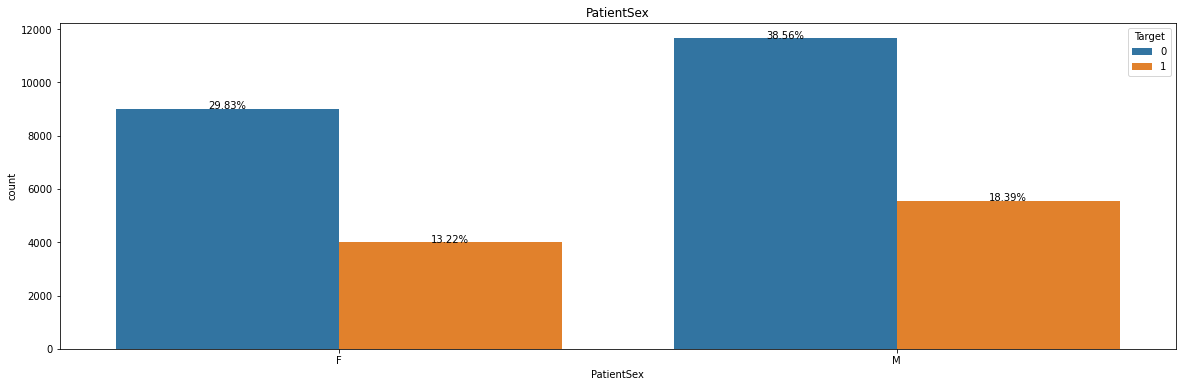

In [57]:
drawgraphs(data_file = training_data, columns = ['PatientSex'], hue = 'Target', width = 20, showdistribution = True)

Thus, we can see that the number of Male patients suffering from Pneumonia is greater when compared with that of Females.

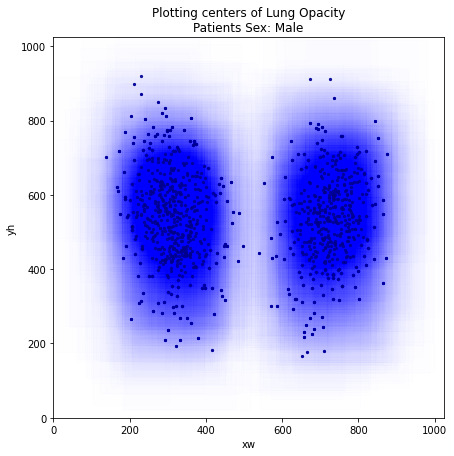

In [58]:
data_male = bboxes[bboxes['PatientSex'] == 'M'].sample(1000)
data_female = bboxes[bboxes['PatientSex'] == 'F'].sample(1000)

bboxes_scatter(data_male, "darkblue", "blue", "Patients Sex: Male")

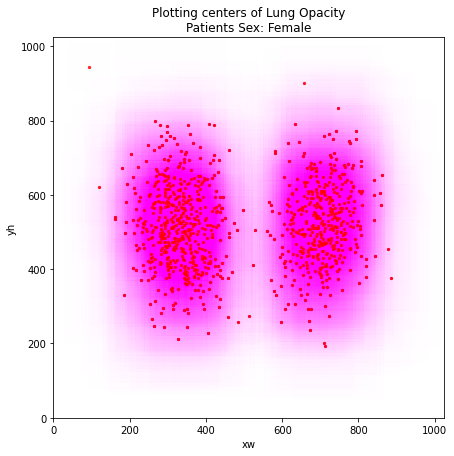

In [59]:
bboxes_scatter(data_female, "red", "magenta", "Patients Sex: Female")

The centres for the bounding box in both the cases are spread out evenly across the entire lung with a slight number of outliers.

#### Patient Age

In [60]:
print('The minimum and maximum recorded age of the patients are {} and {} respectively.'.format(training_data['PatientAge'].min(), training_data['PatientAge'].max()))

The minimum and maximum recorded age of the patients are 1 and 155 respectively.


The number of outliers in `PatientAge` out of 30277 records are:  5

The ages which are in the outlier categories are: [148, 151, 153, 150, 155]


Text(0.5, 1.0, 'Outliers in PatientAge')

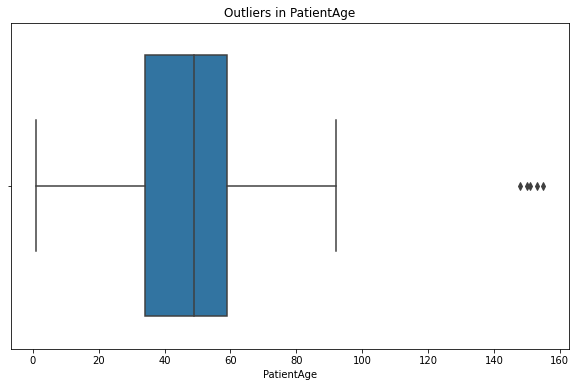

In [61]:
age_25 = np.percentile(training_data['PatientAge'], 25)
age_75 = np.percentile(training_data['PatientAge'], 75)
iqr_age = age_75 - age_25
cutoff_age = 1.5 * iqr_age

low_lim_age = age_25 - cutoff_age
upp_lim_age = age_75 + cutoff_age

outlier_age = [x for x in training_data['PatientAge'] if x < low_lim_age or x > upp_lim_age]
print('The number of outliers in `PatientAge` out of 30277 records are: ', len(outlier_age))
print('\nThe ages which are in the outlier categories are:', outlier_age)

fig = plt.figure(figsize = (10, 6))
sns.boxplot(training_data['PatientAge'], orient = 'h').set_title('Outliers in PatientAge')

Thus, we can say that the ages like 148, 150, 151, 153 and 155 are mistakes. We can trim these outlier values to a somewhat lower value say 100 so that the max age of the patient will be 100.

Creating graph for : ['PatientAge']


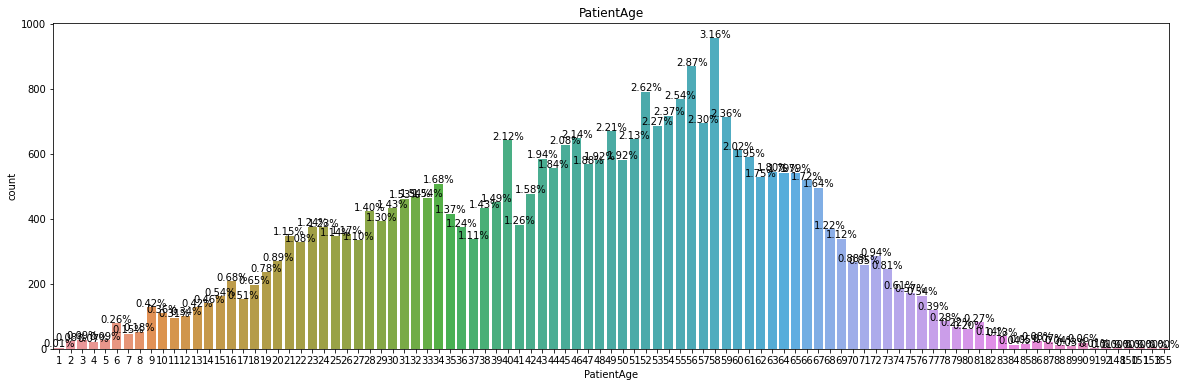

In [62]:
drawgraphs(data_file = training_data, columns = ['PatientAge'], width = 20, showdistribution = True)

Here, we can see that the maximum number of patient are of 58 years old. In order to have a more clear idea, we will introduce a new column where the patients will be placed in an age group like (0, 10), (10, 20) etc.

In [63]:
print('Removing the outliers from `PatientAge`')
training_data['PatientAge'] = training_data['PatientAge'].clip(training_data['PatientAge'].min(), 100)
training_data['PatientAge'].describe().astype(int)

Removing the outliers from `PatientAge`


count     30227
unique       93
top          58
freq        955
Name: PatientAge, dtype: int64

Distribution of `PatientAge`: Overall and Target = 1


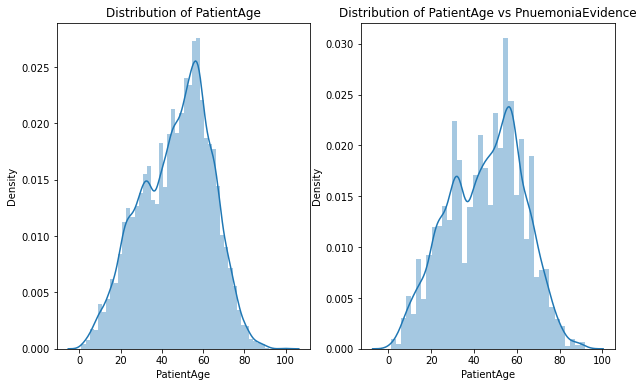

In [64]:
print('Distribution of `PatientAge`: Overall and Target = 1')
fig = plt.figure(figsize = (10, 6))

ax = fig.add_subplot(121)
g = (sns.distplot(training_data['PatientAge']).set_title('Distribution of PatientAge'))

ax = fig.add_subplot(122)
g = (sns.distplot(training_data.loc[training_data['Target'] == 1, 'PatientAge']).set_title('Distribution of PatientAge vs PnuemoniaEvidence'))

In [65]:
custom_array = np.linspace(0, 100, 11)
training_data['PatientAgeBins'] = pd.cut(training_data['PatientAge'], custom_array)
training_data['PatientAgeBins'].value_counts()

(50.0, 60.0]     7446
(40.0, 50.0]     5671
(60.0, 70.0]     4730
(30.0, 40.0]     4551
(20.0, 30.0]     3704
(10.0, 20.0]     1688
(70.0, 80.0]     1637
(0.0, 10.0]       515
(80.0, 90.0]      275
(90.0, 100.0]      10
Name: PatientAgeBins, dtype: int64

Thus, we can see that the maximum number of patients belong to the age group of (50, 60] whereas the least belong to (90, 100]

In [66]:
print('After adding the bin column, the dataset turns out to be:\n')
training_data.head()

After adding the bin column, the dataset turns out to be:



,patientId,x,y,width,height,Target,number_of_boxes,class,path,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing,PatientAgeBins
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/gdrive/MyDrive/AIML/Projects/CV - Pne...,CR,51,F,CHEST,PA,WSD,1024,1024,0.143,"(50.0, 60.0]"
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/gdrive/MyDrive/AIML/Projects/CV - Pne...,CR,48,F,CHEST,PA,WSD,1024,1024,0.194,"(40.0, 50.0]"
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,1,No Lung Opacity / Not Normal,/content/gdrive/MyDrive/AIML/Projects/CV - Pne...,CR,19,M,CHEST,AP,WSD,1024,1024,0.168,"(10.0, 20.0]"
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,1,Normal,/content/gdrive/MyDrive/AIML/Projects/CV - Pne...,CR,28,M,CHEST,PA,WSD,1024,1024,0.143,"(20.0, 30.0]"
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,2,Lung Opacity,/content/gdrive/MyDrive/AIML/Projects/CV - Pne...,CR,32,F,CHEST,AP,WSD,1024,1024,0.139,"(30.0, 40.0]"


Creating graph for : ['PatientAgeBins']


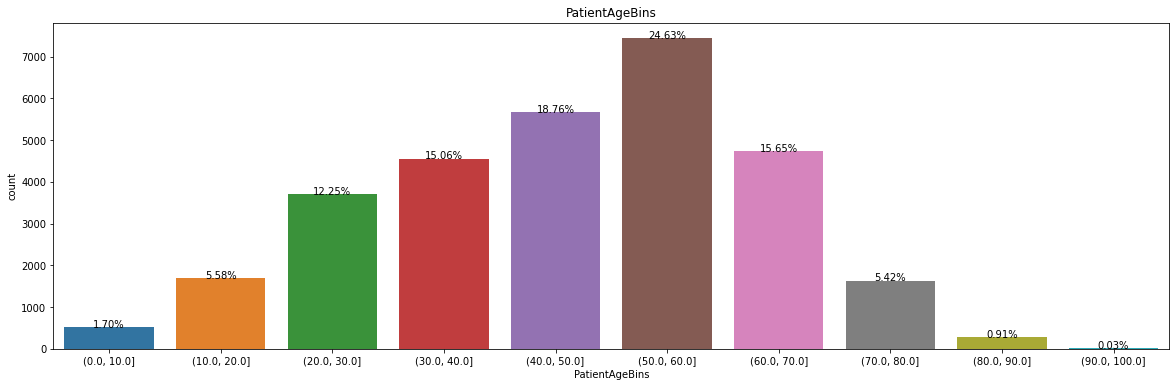

In [67]:
drawgraphs(data_file = training_data, columns = ['PatientAgeBins'], width = 20, showdistribution = True)

Creating graph for: ['PatientAgeBins'] and PatientSex


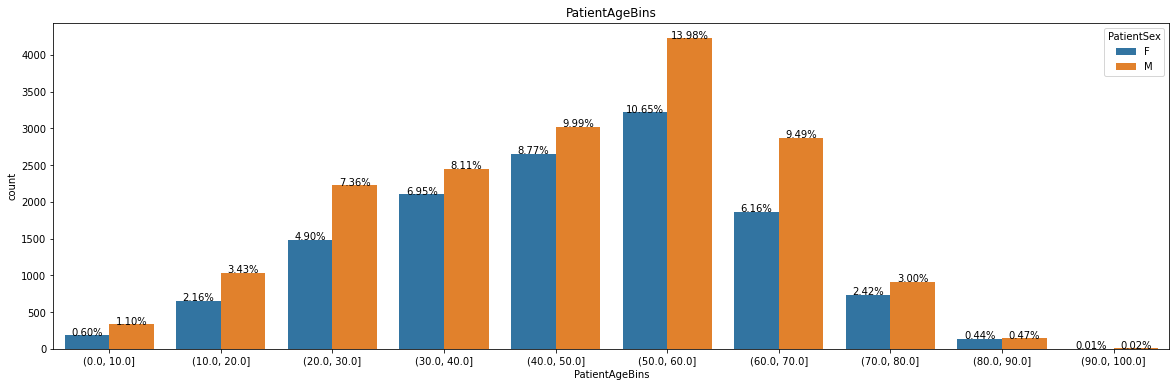

In [68]:
drawgraphs(data_file = training_data, columns = ['PatientAgeBins'], hue = 'PatientSex', width = 20, showdistribution = True)

Creating graph for: ['PatientAgeBins'] and class


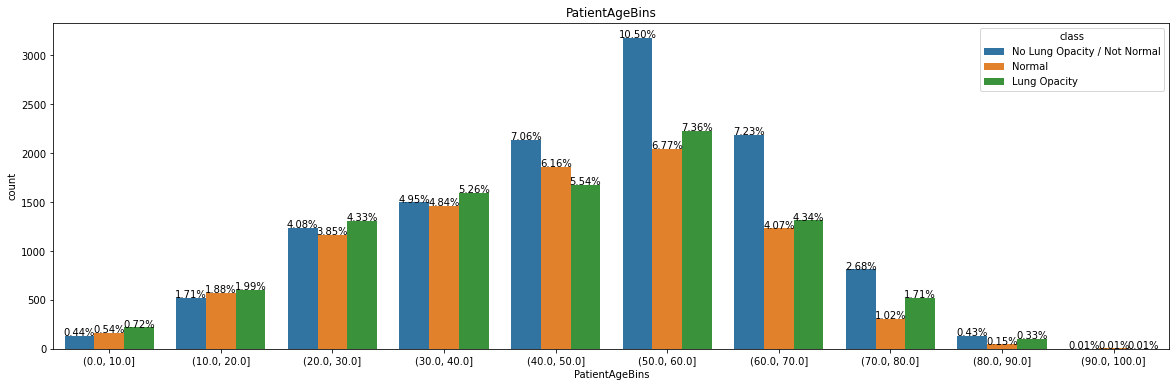

In [69]:
drawgraphs(data_file = training_data, columns = ['PatientAgeBins'], hue = 'class', width = 20, showdistribution = True)

Creating graph for: ['PatientAgeBins'] and Target


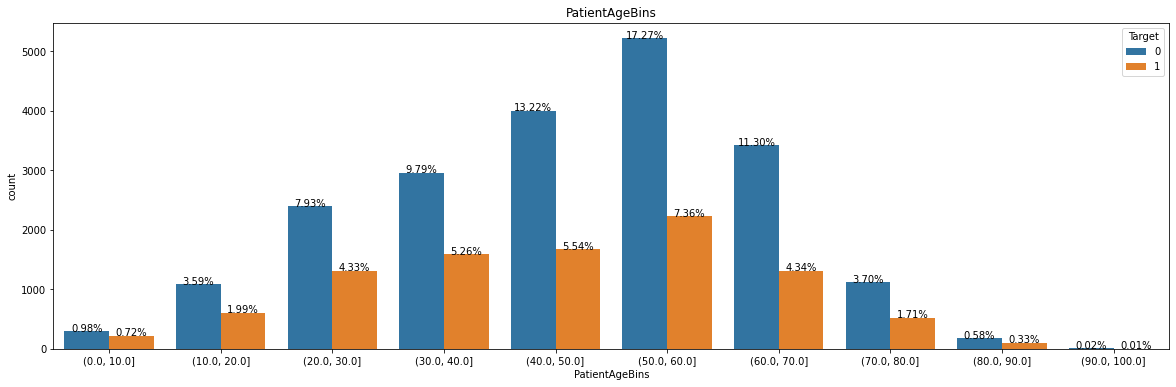

In [70]:
drawgraphs(data_file = training_data, columns = ['PatientAgeBins'], hue = 'Target', width = 20, showdistribution = True)

From the above three plots we can infer that the maximum percentage of Male and Females, Patients with “No Lung Opacity / Not Normal” as well as “Lung Opacity” classes and Patients having Pneumonia all lies in the [50, 60] age group.

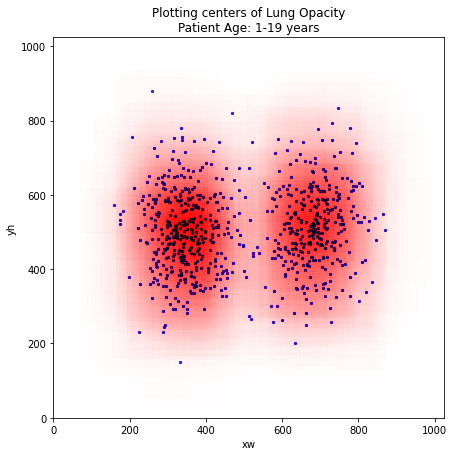

In [71]:
data_age_19 = bboxes[bboxes['PatientAge'] < 20]
data_age_20_34 = bboxes[(bboxes['PatientAge'] >= 20) & (bboxes['PatientAge'] < 35)]
data_age_35_49 = bboxes[(bboxes['PatientAge'] >= 35) & (bboxes['PatientAge'] < 50)]
data_age_50_64 = bboxes[(bboxes['PatientAge'] >= 50) & (bboxes['PatientAge'] < 65)]
data_age_65 = bboxes[bboxes['PatientAge'] >= 65]

bboxes_scatter(data_age_19,'blue', 'red', 'Patient Age: 1-19 years')

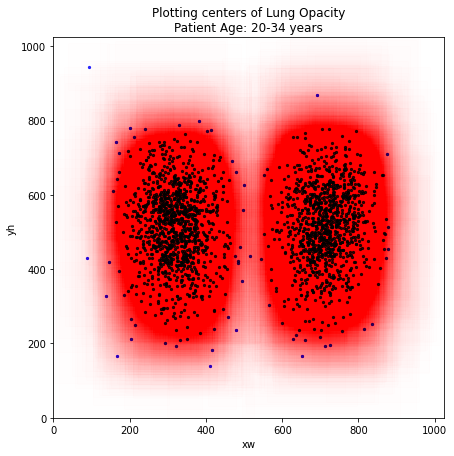

In [72]:
bboxes_scatter(data_age_20_34, 'blue', 'red', 'Patient Age: 20-34 years')

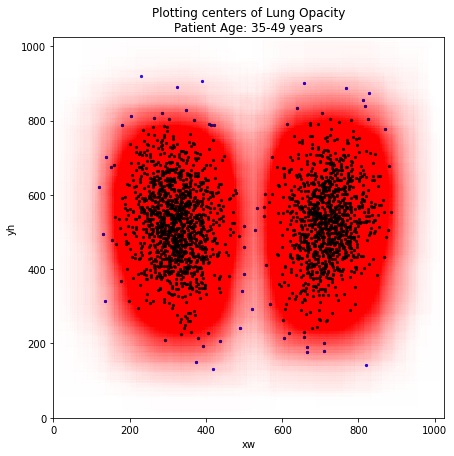

In [73]:
bboxes_scatter(data_age_35_49, 'blue', 'red', 'Patient Age: 35-49 years')

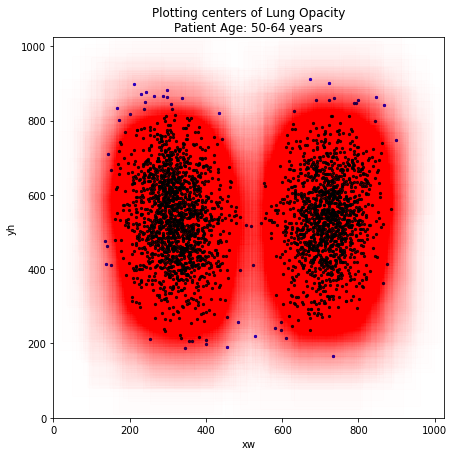

In [74]:
bboxes_scatter(data_age_50_64, 'blue', 'red', 'Patient Age: 50-64 years')

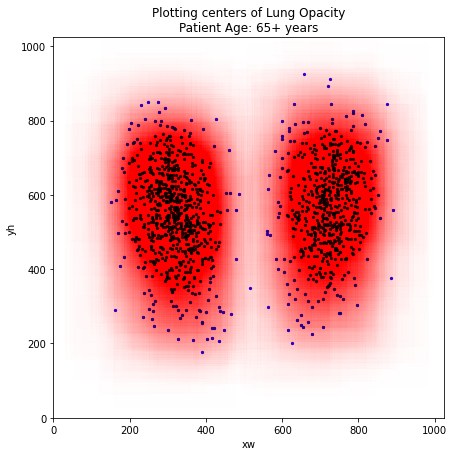

In [75]:
bboxes_scatter(data_age_65, 'blue', 'red', 'Patient Age: 65+ years')

#### Plotting DICOM Images

In [76]:
def show_dicom_images(data, df, img_path):
  img_data = list(data.T.to_dict().values())
  f, ax = plt.subplots(3, 3, figsize = (16, 18))
  
  for i, row in enumerate(img_data):
    image = row['patientId'] + '.dcm'
    path = os.path.join(img_path, image)
    data = dcm.read_file(path)
    rows = df[df['patientId'] == row['patientId']]
    age = rows.PatientAge.unique().tolist()[0]
    sex = data.PatientSex
    part = data.BodyPartExamined
    vp = data.ViewPosition
    modality = data.Modality
    data_img = dcm.dcmread(path)
    ax[i//3, i%3].imshow(data_img.pixel_array, cmap = plt.cm.bone)
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title('ID: {}\nAge: {}, Sex: {}, Part: {}, VP: {}, Modality: {}\nTarget: {}, Class: {}\nWindow: {}:{}:{}:{}'\
                            .format(row['patientId'], age, sex, part,
                                    vp, modality, row['Target'],
                                    row['class'], row['x'],
                                    row['y'], row['width'],
                                    row['height']))
    box_data = list(rows.T.to_dict().values())
    
    for j, row in enumerate(box_data):
      ax[i//3, i%3].add_patch(Rectangle(xy = (row['x'], row['y']),
                                        width = row['width'], height = row['height'],
                                        color = 'blue', alpha = 0.15))
  plt.show()

- Target = 0

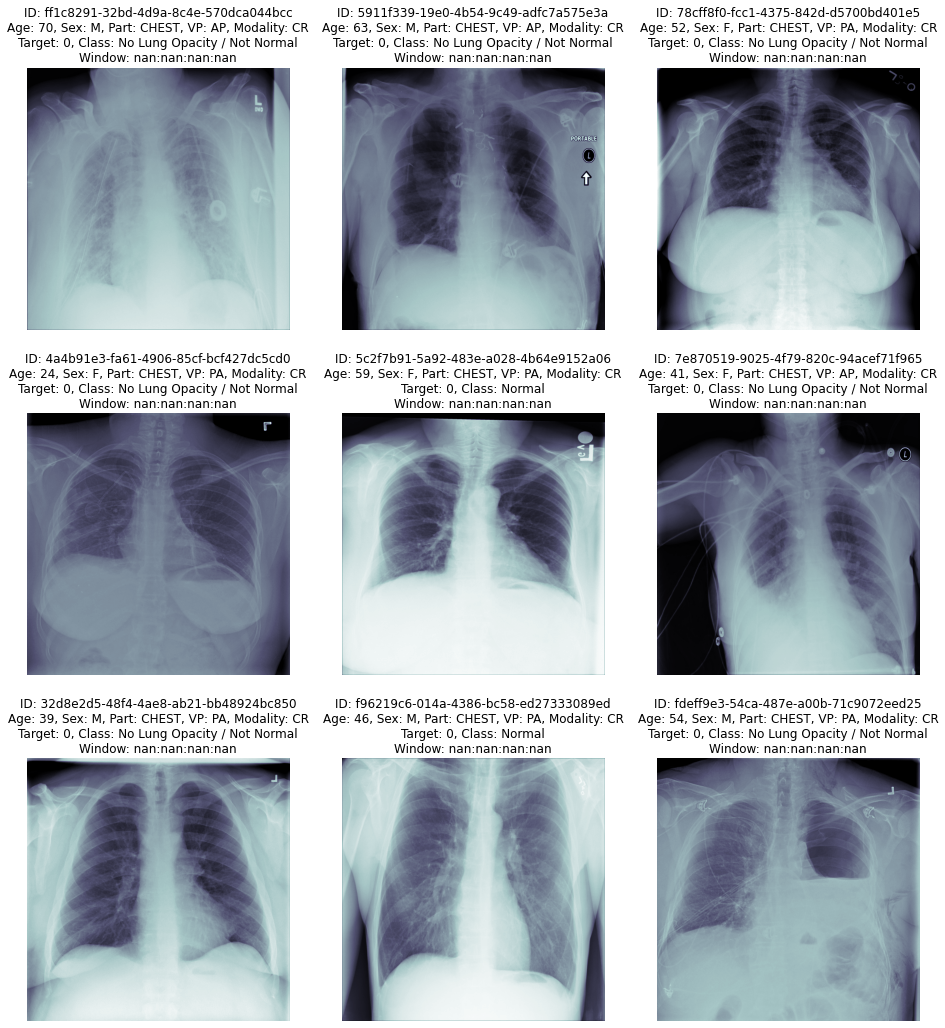

In [78]:
show_dicom_images(data = training_data.loc[(training_data['Target'] == 0)].sample(9),
                  df = training_data, img_path = '/content/gdrive/MyDrive/AIML/Projects/CV - Pneumonia Detection/stage_2_train_images/')

As the above subplots are of the images which belong to either "Normal" or "No Lung Opacity / Not Normal", hence no bounding box is observed.

- Target = 1

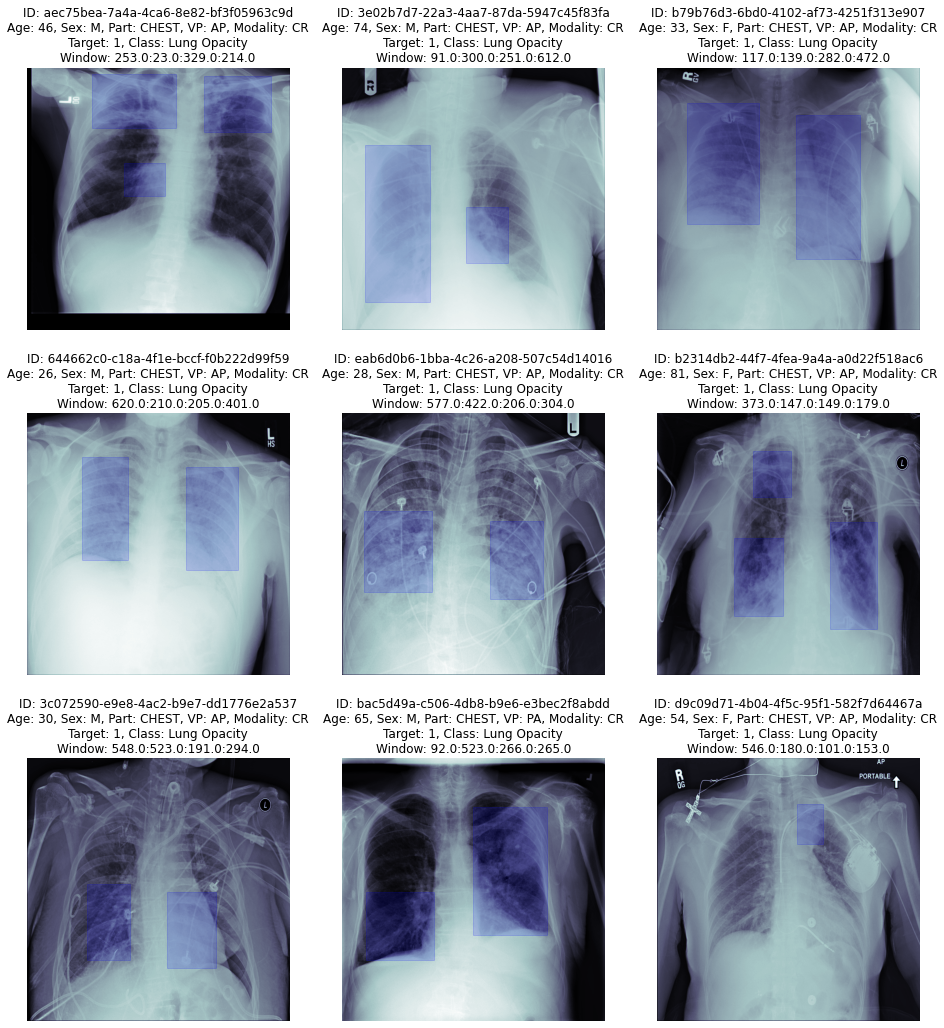

In [77]:
show_dicom_images(data = training_data.loc[(training_data['Target'] == 1)].sample(9),
                  df = training_data, img_path = '/content/gdrive/MyDrive/AIML/Projects/CV - Pneumonia Detection/stage_2_train_images/')

In the above subplots, we can see that the area covered by the box (in blue colour) depicts the area of interest i.e., the area in which the opacity is observed in the Lungs.

### Conclusion
- The training dataset (both of the csv files and the training image folder) contains information of 26684 patients (unique)
- Out of these 26684 unique patients some of these have multiple entries in the both of the csv files
- Most of the recorded patient belong to Target = 0 (i.e., they don't have Pneumonia)
- Some of the patients have more than one bounding box. The maximum being 4
- The classes "No Lung Opacity / Not Normal" and "Normal" is associated with Target = 0 whereas "Lung Opacity" belong to Target = 1
- The images are present in dicom format, from which information like PatientAge, PatientSex, ViewPosition etc are obtained
- There are two ways from which images were obtained: AP and PA. The age ranges from 1-155 (which were further clipped to 100)
- The centers of the bounding box are spread out over the entire region of the lungs. But there are some centers which are outliers.